## 실제 학습

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import os
from network.clip_classifier import TtoTClassifier
import random

# random seed 고정
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
np.random.seed(random_seed)
random.seed(random_seed)

# GPU 번호 지정
gpu_number = 3  # 원하는 GPU 번호로 변경 가능

# GPU 사용 제한
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [2]:
# 데이터 로드
save_path = Path('/home/lbw/CLODE_scores_npy')
results = np.load(save_path / 'results.npy')
brightness_scores = np.load(save_path / 'brightness_scores.npy')  # [idx, T_value, score] 형태
noisiness_scores = np.load(save_path / 'noisiness_scores.npy')    # [idx, T_value, score] 형태
quality_scores = np.load(save_path / 'quality_scores.npy')        # [idx, T_value, score] 형태
print(results.shape, brightness_scores.shape, noisiness_scores.shape, quality_scores.shape)
print(brightness_scores[:31, :3])
# 데이터 로드
results[:, 0]

(485, 2) (14550, 3) (14550, 3) (14550, 3)
[[0.         2.         0.2251503 ]
 [0.         2.10344828 0.22201511]
 [0.         2.20689655 0.21846218]
 [0.         2.31034483 0.21438897]
 [0.         2.4137931  0.20992739]
 [0.         2.51724138 0.20518544]
 [0.         2.62068966 0.20036386]
 [0.         2.72413793 0.19544558]
 [0.         2.82758621 0.19065985]
 [0.         2.93103448 0.18579769]
 [0.         3.03448276 0.18119612]
 [0.         3.13793103 0.17657979]
 [0.         3.24137931 0.17229149]
 [0.         3.34482759 0.16810448]
 [0.         3.44827586 0.16402602]
 [0.         3.55172414 0.1600949 ]
 [0.         3.65517241 0.1564157 ]
 [0.         3.75862069 0.15285362]
 [0.         3.86206897 0.14940675]
 [0.         3.96551724 0.14606631]
 [0.         4.06896552 0.14296414]
 [0.         4.17241379 0.13969548]
 [0.         4.27586207 0.13652584]
 [0.         4.37931034 0.13337375]
 [0.         4.48275862 0.13031524]
 [0.         4.5862069  0.12745118]
 [0.         4.6896551

array([3.03448276, 3.44827586, 2.93103448, 2.        , 3.86206897,
       4.37931034, 3.44827586, 3.55172414, 5.        , 4.06896552,
       2.31034483, 2.20689655, 4.89655172, 5.        , 4.68965517,
       3.24137931, 4.68965517, 5.        , 2.20689655, 4.37931034,
       3.44827586, 4.68965517, 4.79310345, 3.34482759, 3.75862069,
       3.75862069, 4.37931034, 3.55172414, 4.27586207, 3.55172414,
       3.65517241, 3.03448276, 3.86206897, 2.51724138, 5.        ,
       5.        , 5.        , 5.        , 3.44827586, 3.34482759,
       4.37931034, 3.75862069, 5.        , 4.06896552, 3.75862069,
       2.4137931 , 3.75862069, 5.        , 4.89655172, 4.17241379,
       3.65517241, 2.62068966, 4.48275862, 3.44827586, 4.37931034,
       4.5862069 , 3.86206897, 4.5862069 , 2.62068966, 3.24137931,
       3.55172414, 3.24137931, 4.48275862, 3.13793103, 3.55172414,
       5.        , 3.65517241, 3.24137931, 4.79310345, 5.        ,
       3.96551724, 3.13793103, 2.72413793, 2.4137931 , 3.34482

총 이미지 수: 485
T 값의 개수: 30
총 데이터 포인트: 14550
T 값 범위: 2.0 ~ 5.0
유니크 T 값 분포:
T 값 2.00: 35개
T 값 2.10: 4개
T 값 2.21: 15개
T 값 2.31: 10개
T 값 2.41: 18개
T 값 2.52: 21개
T 값 2.62: 19개
T 값 2.72: 28개
T 값 2.83: 17개
T 값 2.93: 30개
T 값 3.03: 23개
T 값 3.14: 25개
T 값 3.24: 20개
T 값 3.34: 14개
T 값 3.45: 26개
T 값 3.55: 19개
T 값 3.66: 15개
T 값 3.76: 21개
T 값 3.86: 20개
T 값 3.97: 11개
T 값 4.07: 14개
T 값 4.17: 12개
T 값 4.28: 5개
T 값 4.38: 9개
T 값 4.48: 9개
T 값 4.59: 6개
T 값 4.69: 6개
T 값 4.79: 3개
T 값 4.90: 5개
T 값 5.00: 25개


/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/IPython/core/pylabtools.

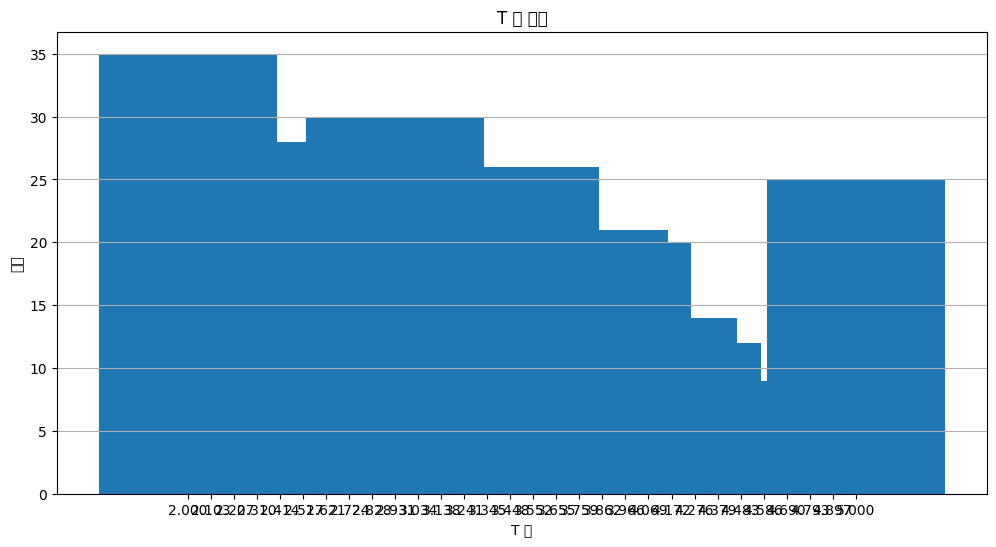

학습 torch.Size([388, 30, 3]) torch.Size([388])
테스트 torch.Size([97, 30, 3]) torch.Size([97])
분할 tensor([2.1034, 3.1379, 4.1724, 2.3103, 2.0000, 2.0000, 3.7586, 2.5172, 3.2414,
        3.8621, 4.0690, 2.5172, 5.0000, 2.6207, 3.6552, 2.5172, 4.4828, 3.6552,
        3.7586, 4.0690, 2.2069, 4.4828, 2.4138, 4.1724, 2.5172, 2.5172, 2.7241,
        2.7241, 2.9310, 3.9655, 2.4138, 2.9310, 2.4138, 4.3793, 3.0345, 2.2069,
        3.1379, 4.6897, 3.5517, 2.7241, 2.0000, 3.5517, 4.5862, 2.0000, 2.2069,
        3.1379, 4.7931, 4.0690, 2.6207, 3.3448, 2.9310, 2.0000, 3.0345, 3.6552,
        2.0000, 3.4483, 3.7586, 3.2414, 2.3103, 2.6207, 3.2414, 4.0690, 3.1379,
        3.4483, 2.7241, 3.4483, 5.0000, 4.0690, 4.8966, 2.7241, 2.5172, 2.7241,
        3.0345, 2.0000, 2.5172, 4.7931, 2.4138, 4.0690, 2.9310, 3.3448, 3.7586,
        3.7586, 3.7586, 2.9310, 2.9310, 3.2414, 3.0345, 3.1379, 4.3793, 2.7241,
        2.9310, 3.8621, 3.6552, 2.9310, 2.7241, 2.7241, 3.2414])
torch.Size([16, 30, 3]) torch.Size([16])


In [3]:
# 회귀 모델 정의
class TtoTRegressor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32):
        super(TtoTRegressor, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # 각 T에 대해 하나의 점수 출력
        )
        
    def forward(self, x):
        # x shape: (batch_size, T, 3)
        batch_size, T, features = x.shape
        x_reshaped = x.reshape(-1, features)  # (batch_size*T, 3)
        scores = self.mlp(x_reshaped).squeeze(-1)  # (batch_size*T,)
        scores = scores.reshape(batch_size, T)  # (batch_size, T)
        
        # 가중 평균으로 최종 T 값 계산
        weights = torch.softmax(scores, dim=1)  # (batch_size, T)
        
        # T 값들에 대한 가중 합
        T_values = torch.FloatTensor(unique_T_values).to(x.device)  # (T,)
        T_pred = torch.sum(weights * T_values.unsqueeze(0), dim=1)  # (batch_size,)
        
        return T_pred

# 데이터 로드
save_path = Path('/home/lbw/CLODE_scores_npy')

# 결과 및 점수 로드
results = np.load(save_path / 'results.npy')
brightness_scores = np.load(save_path / 'brightness_scores.npy')  # [idx, T_value, score] 형태
noisiness_scores = np.load(save_path / 'noisiness_scores.npy')    # [idx, T_value, score] 형태
quality_scores = np.load(save_path / 'quality_scores.npy')        # [idx, T_value, score] 형태

# 데이터 형태 확인 및 재구성
unique_img_indices = np.unique(brightness_scores[:, 0]).astype(int)
# print(unique_img_indices)
num_images = len(unique_img_indices)
unique_T_values = np.unique(brightness_scores[:, 1])
# print(unique_T_values_2)
num_T = len(unique_T_values)

print(f"총 이미지 수: {num_images}")
print(f"T 값의 개수: {num_T}")
print(f"총 데이터 포인트: {len(brightness_scores)}")
print(f"T 값 범위: {unique_T_values.min()} ~ {unique_T_values.max()}")

# 데이터 재구성 (N, T, 3) 형태로
X = np.zeros((num_images, num_T, 3))

# 각 이미지, 각 T값에 대한 점수 할당
for i in range(len(brightness_scores)):
    img_idx = int(brightness_scores[i, 0])
    img_pos = np.where(unique_img_indices == img_idx)[0][0]  # 인덱스의 위치 찾기
    t_val = brightness_scores[i, 1]
    t_idx = np.where(unique_T_values == t_val)[0][0]
    
    X[img_pos, t_idx, 0] = brightness_scores[i, 2]  # 밝기 점수
    X[img_pos, t_idx, 1] = noisiness_scores[i, 2]   # 잡음 점수
    X[img_pos, t_idx, 2] = quality_scores[i, 2]     # 품질 점수

y = np.zeros(num_images, dtype=int)

y = results[:, 0]

# 유니크 값과 각 값의 개수 확인
unique_values, counts = np.unique(y, return_counts=True)

# 결과 출력
print("유니크 T 값 분포:")
for value, count in zip(unique_values, counts):
    print(f"T 값 {value:.2f}: {count}개")

# 데이터 분포 시각화
plt.figure(figsize=(12, 6))
plt.bar(unique_values, counts)
plt.xlabel('T 값')
plt.ylabel('개수')
plt.title('T 값 분포')
plt.grid(axis='y')
plt.xticks(unique_values)
# plt.savefig(save_path / 'T_value_distribution.png')
plt.show()



# 데이터를 torch tensor로 변환
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)
# print(X.shape, y.shape)
# print(y)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('학습', X_train.shape, y_train.shape)
print('테스트', X_test.shape, y_test.shape)
print('분할', y_test)

# 데이터 로더 확인
batch_size = 16
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

input_dim = 3
hidden_dim = 32
classifier = TtoTRegressor(input_dim, hidden_dim).to(device)

# 예시 데이터 확인
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    x_sample = X_batch[0]
    y_sample = y_batch[0]
    print(x_sample)
    for i in range(batch_size):
        print(y_batch[i])
    print(y_sample)
    # 모델 출력
    outputs = classifier(X_batch)
    print(outputs.shape)
    break


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# 회귀 모델 정의
class TtoTRegressor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32):
        super(TtoTRegressor, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(),
            # nn.Linear(hidden_dim*2, hidden_dim*4),
            # nn.ReLU(),
            # nn.Linear(hidden_dim*4, hidden_dim*4),
            # nn.ReLU(),
            # nn.Linear(hidden_dim*4, hidden_dim*4),
            # nn.ReLU(),
            # nn.Linear(hidden_dim*4, hidden_dim*2),
            # nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # 각 T에 대해 하나의 점수 출력
        )
        
    def forward(self, x):
        # x shape: (batch_size, T, 3)
        batch_size, T, features = x.shape
        x_reshaped = x.reshape(-1, features)  # (batch_size*T, 3)
        scores = self.mlp(x_reshaped).squeeze(-1)  # (batch_size*T,)
        scores = scores.reshape(batch_size, T)  # (batch_size, T)
        
        # 가중 평균으로 최종 T 값 계산
        weights = torch.softmax(scores, dim=1)  # (batch_size, T)
        
        # T 값들에 대한 가중 합
        T_values = torch.FloatTensor(unique_T_values).to(x.device)  # (T,)
        T_pred = torch.sum(weights * T_values.unsqueeze(0), dim=1)  # (batch_size,)
        
        return T_pred



# 학습 루프
num_epochs = 2000
train_losses = []
test_losses = []
best_test_loss = 10
best_epoch = 0
learning_rate = 1e-4

input_dim = 3
hidden_dim = 32
num_layers=6

# 모델, 손실 함수, 옵티마이저 초기화
regressor = TtoTRegressor(input_dim, hidden_dim).to(device)
# criterion_reg = nn.MSELoss()  # 회귀 문제이므로 MSE 손실 사용
criterion_reg = nn.L1Loss()  # MAE 손실 사용

optimizer_reg = optim.Adam(regressor.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode='min', factor=0.5, patience=10, verbose=True)


for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    regressor.train()
    epoch_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # 예측 및 손실 계산
        y_pred = regressor(X_batch)
        loss = criterion_reg(y_pred, y_batch)
        
        # 역전파 및 최적화
        optimizer_reg.zero_grad()
        loss.backward()
        optimizer_reg.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # 테스트 데이터로 평가
    regressor.eval()
    test_loss = 0.0
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = regressor(X_batch)
            test_loss += criterion_reg(y_pred, y_batch).item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = classifier.state_dict()
            best_epoch = epoch
    
    
    # if (epoch + 1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')


# 모델 저장
model_path = "/home/lbw/CLODE_model"
model_path = Path(model_path)
model_path.mkdir(exist_ok=True, parents=True)

model_name = f'tto_regression_{num_layers}_{hidden_dim}_{learning_rate}_{best_epoch}.pth'

torch.save(best_model, model_path / model_name)
print(f"epoch{epoch}_모델 학습 및 저장 완료!")


# 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig(model_path / 'regression_training.png')
plt.show()

# 예측 평가
regressor.eval()
with torch.no_grad():
    X_test_reg_device = X_test.to(device)
    y_pred = regressor(X_test_reg_device).cpu().numpy()
    y_true = y_test.numpy()
    
    # 평균 절대 오차 (MAE) 계산
    mae = np.mean(np.abs(y_pred - y_true))
    # 평균 제곱근 오차 (RMSE) 계산
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    
    # 예측 vs 실제 시각화
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True T')
    plt.ylabel('Predicted T')
    plt.title('Regression Results: True vs Predicted T')
    plt.grid(True)
    plt.savefig(model_path / f'regression_results_{hidden_dim}_{learning_rate}_{best_epoch}.png')
    plt.show()

with torch.no_grad():
    X_test_reg_device = X_train.to(device)
    y_pred = regressor(X_test_reg_device).cpu().numpy()
    y_true = y_train.numpy()
    
    # 평균 절대 오차 (MAE) 계산
    mae = np.mean(np.abs(y_pred - y_true))
    # 평균 제곱근 오차 (RMSE) 계산
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    
    # 예측 vs 실제 시각화
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True T')
    plt.ylabel('Predicted T')
    plt.title('Regression Results: True vs Predicted T')
    plt.grid(True)
    plt.savefig(model_path / f'regression_results_{hidden_dim}_{learning_rate}_{best_epoch}.png')
    plt.show()

/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

Training Progress:  31%|███▏      | 626/2000 [00:45<01:37, 14.05it/s]

In [5]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from pathlib import Path
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt

# # 회귀 모델 정의
# class TtoTRegressor_multi(nn.Module):
#     def __init__(self, input_dim=3, hidden_dim=32):
#         super(TtoTRegressor_multi, self).__init__()
#         # 데이터 형태 가져오기
#         batch_size, T, features = X.shape  # X는 전역 변수로 정의되어 있어야 함
#         self.T = T  # 클래스 변수로 T 저장
        
#         # 입력 차원: 각 배치에 대해 T*features
#         total_input_dim = T * features
        
#         self.mlp = nn.Sequential(
#             nn.Linear(total_input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, T)  # 출력은 각 T에 대한 점수
#         )
        
#     def forward(self, x):
#         # x shape: (batch_size, T, features)
#         batch_size, T, features = x.shape
#         x_reshaped = x.reshape(batch_size, T*features)  # (batch_size, T*features)
        
#         # MLP를 통과시켜 각 T에 대한 점수 계산
#         scores = self.mlp(x_reshaped)  # (batch_size, T)
        
#         # 가중 평균으로 최종 T 값 계산
#         weights = torch.softmax(scores, dim=1)  # (batch_size, T)
        
#         # T 값들에 대한 가중 합
#         T_values = torch.FloatTensor(unique_T_values).to(x.device)  # (T,)
#         T_pred = torch.sum(weights * T_values.unsqueeze(0), dim=1)  # (batch_size,)
        
#         return T_pred



# # 학습 루프
# num_epochs = 1000
# train_losses = []
# test_losses = []
# best_test_loss = 10
# best_epoch = 0
# learning_rate = 1e-4

# input_dim = 3
# hidden_dim = 64

# # 모델, 손실 함수, 옵티마이저 초기화
# regressor = TtoTRegressor_multi(input_dim, hidden_dim).to(device)
# criterion_reg = nn.MSELoss()  # 회귀 문제이므로 MSE 손실 사용
# optimizer_reg = optim.Adam(regressor.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode='min', factor=0.5, patience=10, verbose=True)


# for epoch in range(num_epochs):
#     regressor.train()
#     epoch_loss = 0.0
    
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)
        
#         # 예측 및 손실 계산
#         y_pred = regressor(X_batch)
#         loss = criterion_reg(y_pred, y_batch)
        
#         # 역전파 및 최적화
#         optimizer_reg.zero_grad()
#         loss.backward()
#         optimizer_reg.step()
        
#         epoch_loss += loss.item()
    
#     avg_train_loss = epoch_loss / len(train_loader)
#     train_losses.append(avg_train_loss)
    
#     # 테스트 데이터로 평가
#     regressor.eval()
#     test_loss = 0.0
#     with torch.no_grad():
#         total = 0
#         correct = 0
#         total_loss = 0
        
#         for X_batch, y_batch in test_loader:
#             X_batch = X_batch.to(device)
#             y_batch = y_batch.to(device)
            
#             y_pred = regressor(X_batch)
#             test_loss += criterion_reg(y_pred, y_batch).item()
    
#     avg_test_loss = test_loss / len(test_loader)
#     test_losses.append(avg_test_loss)
    
#     if test_loss < best_test_loss:
#             best_test_loss = test_loss
#             best_model = classifier.state_dict()
#             best_epoch = epoch
    
    
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')


# # 모델 저장
# model_path = "/home/lbw/CLODE_model"
# model_path = Path(model_path)
# model_path.mkdir(exist_ok=True, parents=True)

# torch.save(best_model, model_path / f'tto_regression_multi_{hidden_dim}_{learning_rate}_{best_epoch}.pth')
# print(f"epoch{epoch}_모델 학습 및 저장 완료!")


# # 결과 시각화
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Train Loss')
# plt.plot(test_losses, label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Mean Squared Error')
# plt.title('Training and Testing Loss')
# plt.legend()
# plt.grid(True)
# plt.savefig(model_path / f'regression_mul_training_{hidden_dim}_{learning_rate}_{best_epoch}.png')
# plt.show()

# # 예측 평가
# regressor.eval()
# with torch.no_grad():
#     X_test_reg_device = X_test.to(device)
#     y_pred = regressor(X_test_reg_device).cpu().numpy()
#     y_true = y_test.numpy()
    
#     # 평균 절대 오차 (MAE) 계산
#     mae = np.mean(np.abs(y_pred - y_true))
#     # 평균 제곱근 오차 (RMSE) 계산
#     rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
#     print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    
#     # 예측 vs 실제 시각화
#     plt.figure(figsize=(8, 8))
#     plt.scatter(y_true, y_pred, alpha=0.6)
#     plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
#     plt.xlabel('True T')
#     plt.ylabel('Predicted T')
#     plt.title('Regression Results: True vs Predicted T')
#     plt.grid(True)
#     plt.savefig(save_path / f'regression_mul_results_{hidden_dim}_{learning_rate}_{best_epoch}.png')
#     plt.show()

## Clip_score based T로 시각화

In [6]:
import torch
from tqdm import tqdm
from network.conv_node import NODE
from network.clip_classifier import TtoTClassifier
from misc import *
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.multimodal import CLIPImageQualityAssessment
import time

# GPU 번호 지정
gpu_number = 3  # 원하는 GPU 번호로 변경 가능

# GPU 사용 제한
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = NODE(device, (3, 256, 256), 32, augment_dim=0, time_dependent=True, adjoint=True)
model.eval()
model.to(device)
model.load_state_dict(torch.load(f'/home/lbw/CLODE/pth/universal.pth', weights_only=True), strict=False)

# 하이퍼파라미터 설정
input_dim = 3
hidden_dim = 64

# 모델 초기화
classifier = TtoTRegressor(input_dim, hidden_dim).to(device)
classifier.eval()
classifier.to(device)
classifier.load_state_dict(torch.load(model_path / model_name, map_location=device))

file_path = Path('/home/lbw/data/eval15')

# img_labels = sorted(os.listdir(file_path / 'low'))
img_labels = [f for f in sorted(os.listdir(file_path / 'low')) if f.lower().endswith('.png')]

# 필요한 함수들 정의
prompts = ('brightness', 'noisiness', 'quality')
clip_metric = CLIPImageQualityAssessment(
    model_name_or_path="openai/clip-vit-base-patch16",
    prompts=prompts
).to(device)

def calculate_clip_score(pred):    
    if len(pred.shape) == 3:
        pred = pred.unsqueeze(0)
    
    with torch.no_grad():
        scores = clip_metric(pred)
    
    return scores[prompts[0]].item(), scores[prompts[1]].item(), scores[prompts[2]].item()

# eval15 데이터 불러오기
eval_path = Path('/home/lbw/data/eval15')
eval_images = [f for f in sorted(os.listdir(eval_path / 'low')) if f.lower().endswith('.png')]

def load_eval_image(idx):
    img_name = eval_images[idx]
    lq_img = image_tensor(eval_path / 'low' / img_name, size=(256, 256))
    gt_img = image_tensor(eval_path / 'high' / img_name, size=(256, 256))
    
    return lq_img.to(device), gt_img.to(device), img_name

def tensor_to_numpy(tensor):
    """PyTorch 텐서를 NumPy 배열로 변환합니다."""
    # GPU -> CPU 이동 및 계산 그래프에서 분리
    img = tensor.detach().cpu().numpy()
    
    # 이미지 형식 변환 (C,H,W) -> (H,W,C)
    if img.ndim == 3 and img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    
    # 값 범위 조정 [0, 1]
    img = np.clip(img, 0, 1)
    
    return img

# 메인 루프 최적화
T_values = np.linspace(2, 5, 30)

# T 값들을 먼저 텐서로 변환하여 반복 변환 방지
T_tensors = [torch.tensor([0, T]).float().cuda() for T in T_values]

# 결과 저장을 위한 디렉토리 생성
results_dir = Path('/home/lbw/CLODE_eval_results_8')
results_dir.mkdir(parents=True, exist_ok=True)

best_Ts = []
pred_Ts = []
best_psnrs = []
pred_psnrs = []

# 이미지별 NODE와 Classifier 결과 비교
for idx in tqdm(range(len(eval_images))):
    lq_img, gt_img, img_name = load_eval_image(idx)
    
    # 모든 T에 대한 예측 수행
    preds = []
    psnrs = []
    
    with torch.no_grad():
        for T_tensor in T_tensors:
            pred = model(lq_img, T_tensor, inference=True)['output'][0]
            preds.append(pred)
            psnr = calculate_psnr(pred, gt_img).item()
            psnrs.append(psnr)
    
    # PSNR 기반 best_T 찾기
    best_T_idx = np.argmax(psnrs)
    best_T = T_values[best_T_idx]
    best_pred = preds[best_T_idx]
    
    best_Ts.append(best_T)
    best_psnrs.append(psnrs[best_T_idx])
    
    # CLIP 점수 계산 및 행렬 구성
    clip_scores = np.zeros((len(preds), 3))
    for i, pred in enumerate(preds):
        bright_score, noise_score, quality_score = calculate_clip_score(pred)
        clip_scores[i] = [bright_score, noise_score, quality_score]
    
    # Classifier 모델로 예측
    clip_scores_tensor = torch.FloatTensor(clip_scores).unsqueeze(0).to(device)  # (1, T, 3) 형태로 변환
    with torch.no_grad():
        outputs = classifier(clip_scores_tensor)
        pred_T_idx = torch.argmax(outputs, dim=1).item()
    
    pred_T = T_values[pred_T_idx]
    pred_img = preds[pred_T_idx]
    
    pred_Ts.append(pred_T)
    pred_psnrs.append(psnrs[pred_T_idx])
    
    # 시각화
    plt.figure(figsize=(20, 15))
    
    # 원본 저화질 이미지
    plt.subplot(2, 2, 1)
    plt.imshow(tensor_to_numpy(lq_img[0]))
    plt.title(f'Low Quality Image: {img_name}')
    plt.axis('off')
    
    # 원본 고화질 이미지
    plt.subplot(2, 2, 2)
    plt.imshow(tensor_to_numpy(gt_img[0]))
    plt.title('Ground Truth')
    plt.axis('off')
    
    # PSNR 기반 best_T 이미지
    plt.subplot(2, 2, 3)
    plt.imshow(tensor_to_numpy(best_pred))
    plt.title(f'NODE Best T={best_T:.2f}, PSNR={psnrs[best_T_idx]:.2f}dB')
    plt.axis('off')
    
    # Classifier 예측 T 이미지
    plt.subplot(2, 2, 4)
    plt.imshow(tensor_to_numpy(pred_img))
    plt.title(f'Classifier Pred T={pred_T:.2f}, PSNR={psnrs[pred_T_idx]:.2f}dB')
    plt.axis('off')
    
    # 결과 저장
    plt.tight_layout()
    plt.savefig(results_dir / f'{img_name.split(".")[0]}_compare.png')
    plt.close()
    # # PSNR 그래프 추가
    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(T_values, psnrs)
    # plt.axvline(x=best_T, color='r', linestyle='--', label=f'Best T={best_T:.2f}')
    # plt.axvline(x=pred_T, color='g', linestyle='--', label=f'Pred T={pred_T:.2f}')
    # plt.xlabel('T values')
    # plt.ylabel('PSNR (dB)')
    # plt.title('PSNR vs T')
    # plt.grid(True)
    # plt.legend()
    
    # # CLIP 점수 그래프
    # plt.subplot(1, 2, 2)
    # plt.plot(T_values, clip_scores[:, 0], label='Brightness')
    # plt.plot(T_values, clip_scores[:, 1], label='Noisiness')
    # plt.plot(T_values, clip_scores[:, 2], label='Quality')
    # plt.axvline(x=best_T, color='r', linestyle='--')
    # plt.axvline(x=pred_T, color='g', linestyle='--')
    # plt.xlabel('T values')
    # plt.ylabel('CLIP Score')
    # plt.title('CLIP Scores vs T')
    # plt.grid(True)
    # plt.legend()
    
    # # 결과 저장
    # plt.tight_layout()
    # plt.savefig(results_dir / f'{img_name.split(".")[0]}_comparison.png')
    # plt.close('all')
    
    # 첫 5개만 처리 후 멈춤 (테스트용, 모든 이미지를 처리하려면 제거)
    # if idx == 4:
    #     break

# 통계 정보 계산 (전체 이미지에 대해)
print("모든 이미지 처리 완료!")

# best_Ts와 pred_Ts를 하나의 플롯에 시각화
plt.figure(figsize=(10, 6))
plt.plot(best_Ts, label='Best Ts (PSNR-based)', marker='o')
plt.plot(pred_Ts, label='Predicted Ts (Classifier-based)', marker='x')
plt.xlabel('Image Index')
plt.ylabel('T Values')
plt.title('Comparison of Best Ts and Predicted Ts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(results_dir / 'best_vs_pred_Ts.png')
plt.show()

# PSNR 비교
print(f"Best T PSNR 평균: {np.mean(best_psnrs):.2f}dB")
print(f"Predicted T PSNR 평균: {np.mean(pred_psnrs):.2f}dB")


/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_4119243/4241583805.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you star

RuntimeError: Error(s) in loading state_dict for TtoTRegressor:
	Missing key(s) in state_dict: "mlp.6.weight", "mlp.6.bias", "mlp.8.weight", "mlp.8.bias", "mlp.10.weight", "mlp.10.bias". 
	size mismatch for mlp.0.weight: copying a param with shape torch.Size([32, 3]) from checkpoint, the shape in current model is torch.Size([64, 3]).
	size mismatch for mlp.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for mlp.2.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for mlp.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for mlp.4.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([256, 128]).
	size mismatch for mlp.4.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([256]).

In [ ]:
if

## 더미 데이터로 테스트

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# GPU 번호 지정
gpu_number = 3  # 원하는 GPU 번호로 변경 가능

# GPU 사용 제한
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# 테스트 데이터 생성을 위한 파라미터 설정
num_images = 100  # 이미지 개수
num_T = 30        # T값 개수
T_values = np.linspace(2, 5, num_T)  # 실제와 같은 범위의 T값

# 저장 경로 설정
save_path = Path('/home/lbw/CLODE_test_data')
save_path.mkdir(parents=True, exist_ok=True)

# 1. 랜덤 데이터 생성
np.random.seed(42)  # 재현성을 위한 시드 설정

# results 배열 생성: 각 이미지에 대한 [best_T, high_psnr]
results = np.zeros((num_images, 2))
for i in range(num_images):
    best_T_idx = np.random.randint(0, num_T)
    results[i, 0] = T_values[best_T_idx]  # best_T
    results[i, 1] = np.random.uniform(20, 40)  # 가상의 PSNR 값

# 각 이미지와 각 T값에 대한 점수 생성
brightness_scores = []
noisiness_scores = []
quality_scores = []

for idx in range(num_images):
    for t_idx, T in enumerate(T_values):
        # best_T와 가까울수록 더 좋은 점수가 나오도록 설정
        proximity = 1 - abs(T - results[idx, 0]) / 3
        
        # 각 점수 생성 (약간의 노이즈 추가)
        bright_score = 0.7 * proximity + 0.3 * np.random.random()
        noise_score = 0.7 * proximity + 0.3 * np.random.random()
        quality_score = 0.8 * proximity + 0.2 * np.random.random()
        
        brightness_scores.append([idx, T, bright_score])
        noisiness_scores.append([idx, T, noise_score])
        quality_scores.append([idx, T, quality_score])

# 배열로 변환
brightness_scores = np.array(brightness_scores)
noisiness_scores = np.array(noisiness_scores)
quality_scores = np.array(quality_scores)

# 데이터 저장
np.save(save_path / 'results.npy', results)
np.save(save_path / 'brightness_scores.npy', brightness_scores)
np.save(save_path / 'noisiness_scores.npy', noisiness_scores)
np.save(save_path / 'quality_scores.npy', quality_scores)

print("테스트 데이터 생성 완료!")

# 2. 모델 정의
class TtoTClassifier(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32):
        super(TtoTClassifier, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        # x shape: (batch_size, T, 3) 또는 (T, 3)
        if len(x.shape) == 2:
            # 단일 이미지에 대한 T개의 스코어 세트
            T, features = x.shape
            scores = self.mlp(x).squeeze(-1)  # (T,)
        else:
            # 배치 처리
            batch_size, T, features = x.shape
            x_reshaped = x.reshape(-1, features)  # (batch_size*T, 3)
            scores = self.mlp(x_reshaped).squeeze(-1)  # (batch_size*T,)
            scores = scores.reshape(batch_size, T)  # (batch_size, T)
        
        return scores

# 3. 데이터 로드 및 전처리
# 생성한 데이터 로드
results = np.load(save_path / 'results.npy')
brightness_scores = np.load(save_path / 'brightness_scores.npy')
noisiness_scores = np.load(save_path / 'noisiness_scores.npy')
quality_scores = np.load(save_path / 'quality_scores.npy')

# 데이터 형태 확인 및 재구성
unique_img_indices = np.unique(brightness_scores[:, 0]).astype(int)
num_images = len(unique_img_indices)
unique_T_values = np.unique(brightness_scores[:, 1])
num_T = len(unique_T_values)

print(f"총 이미지 수: {num_images}")
print(f"T 값의 개수: {num_T}")
print(f"총 데이터 포인트: {len(brightness_scores)}")
print(f"T 값 범위: {unique_T_values.min()} ~ {unique_T_values.max()}")

# 데이터 재구성 (N, T, 3) 형태로
X = np.zeros((num_images, num_T, 3))

# 각 이미지, 각 T값에 대한 점수 할당
for i in range(len(brightness_scores)):
    img_idx = int(brightness_scores[i, 0])
    img_pos = np.where(unique_img_indices == img_idx)[0][0]  # 인덱스의 위치 찾기
    t_val = brightness_scores[i, 1]
    t_idx = np.where(unique_T_values == t_val)[0][0]
    
    X[img_pos, t_idx, 0] = brightness_scores[i, 2]  # 밝기 점수
    X[img_pos, t_idx, 1] = noisiness_scores[i, 2]   # 잡음 점수
    X[img_pos, t_idx, 2] = quality_scores[i, 2]     # 품질 점수

# results에서 best_T 값을 T_values 내의 인덱스로 변환
y = np.zeros(num_images, dtype=int)
for i in range(num_images):
    best_T = results[i, 0]
    # 가장 가까운 T_value 인덱스 찾기
    y[i] = np.abs(unique_T_values - best_T).argmin()

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 텐서로 변환
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 데이터 로더 확인
batch_size = 16
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

input_dim = 3
hidden_dim = 32
model = TtoTClassifier(input_dim, hidden_dim).to(device)

# 예시 데이터 확인
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    
    # 모델 출력
    outputs = model(X_batch)
    print(outputs.shape)
    break

테스트 데이터 생성 완료!
총 이미지 수: 100
T 값의 개수: 30
총 데이터 포인트: 3000
T 값 범위: 2.0 ~ 5.0
torch.Size([16, 30, 3]) torch.Size([16])
torch.Size([16, 30])


모델 학습 시작...
Epoch 10/100, Loss: 3.2193, Accuracy: 0.2000
Epoch 20/100, Loss: 2.7475, Accuracy: 0.2500
Epoch 30/100, Loss: 2.1513, Accuracy: 0.2500
Epoch 40/100, Loss: 1.8007, Accuracy: 0.2500
Epoch 50/100, Loss: 1.6416, Accuracy: 0.2500
Epoch 60/100, Loss: 1.5717, Accuracy: 0.2500
Epoch 70/100, Loss: 1.5350, Accuracy: 0.3000
Epoch 80/100, Loss: 1.5127, Accuracy: 0.3000
Epoch 90/100, Loss: 1.4991, Accuracy: 0.3000
Epoch 100/100, Loss: 1.4911, Accuracy: 0.3000


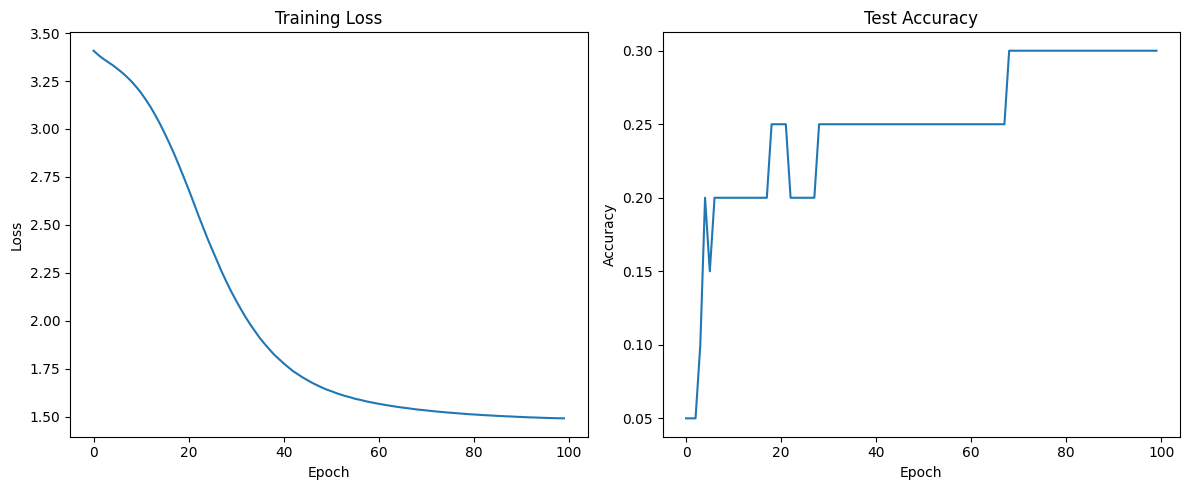

최종 테스트 정확도: 0.3000
모델 학습 및 저장 완료!


In [ ]:

# 4. 모델 훈련
# 하이퍼파라미터 설정
input_dim = 3
hidden_dim = 32
learning_rate = 0.001
num_epochs = 100
batch_size = 16

# 모델 초기화
model = TtoTClassifier(input_dim, hidden_dim).to(device)

# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 데이터 로더 확인
batch_size = 16
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)\

# 학습 로직
train_losses = []
test_accuracies = []

print("모델 학습 시작...")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # 모델 출력
        outputs = model(X_batch)
        
        # 손실 계산
        loss = criterion(outputs, y_batch)
        
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / ((len(X_train) - 1) // batch_size + 1)
    train_losses.append(avg_loss)
    
    # 테스트 데이터로 평가
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            predictions = torch.argmax(outputs, dim=1)
            total += y_batch.size(0)
            correct += (predictions == y_batch).sum().item()
        
        accuracy = correct / total
        test_accuracies.append(accuracy)
        
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

# 결과 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig(save_path / 'training_results.png')
plt.show()

print(f"최종 테스트 정확도: {test_accuracies[-1]:.4f}")

# 모델 저장
model_path = "/home/lbw/CLODE_test_model"
model_path = Path(model_path)
model_path.mkdir(exist_ok=True, parents=True)

torch.save(model.state_dict(), model_path / 'tto_classifier.pth')

print("모델 학습 및 저장 완료!")